In [1]:
import sys ; sys.path.append('../')
from load import RIR
from acoustic_params import Acoustic_params
from filterbank import Filterbank
from scipy import stats
import librosa
import scipy
import numpy as np
import matplotlib.pyplot as plt

from augmentation import *

params = {'fs' : 16000,
          'bands' : [125, 250, 500, 1000, 2000, 4000],
          'bandsize' : 1,
          'order' : 4,
          'f_length': 16384,'power' : True}
filterbank = Filterbank(**params)


## Standarization

In [2]:
impulso = RIR('../files/rir.wav', fs=params['fs'])
delay, early, rir = preprocess_rir(impulso.rir, impulso.fs) # rir = late
t = np.linspace(0, len(rir)/impulso.fs, len(rir)) # vector temporal

Estoy estimando envolventes. Entonces, tengo que darle al estimador la ecuacion correspondiente a la envolvente, y tambien la curva envolvente a estimar (a fitear). La envolvente la obtengo descartando el ruido del modelo. Esto lo puedo hacer tomando promedios (ya que el ruido tiene media cero) lo que equivale a aplicar un filtro de media movil.

## Fullband estimation

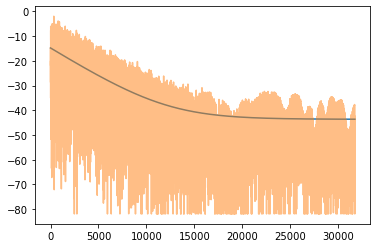

In [3]:
fullband_params = curve_fit(t, rir) # Am, decay, noise_floor
plt.plot(curve_model(t, *fullband_params))
plt.plot(librosa.amplitude_to_db(rir), alpha = 0.5); plt.show()

# Sub-band decomposition

Se hace la descomposicion por bandas. Aca entra un paso muy importante que es el de detectar el piso de ruido para poder eliminarlo. Se hace la estimacion de envolvente, se detecta el onset del piso de ruido. Con ese dato, se puede extender la respuesta mas alla del piso de ruido de manera sencilla, utilizando los parametros estimados modificando el piso de ruido a cero y haciendo un crossfade en el punto del onset.

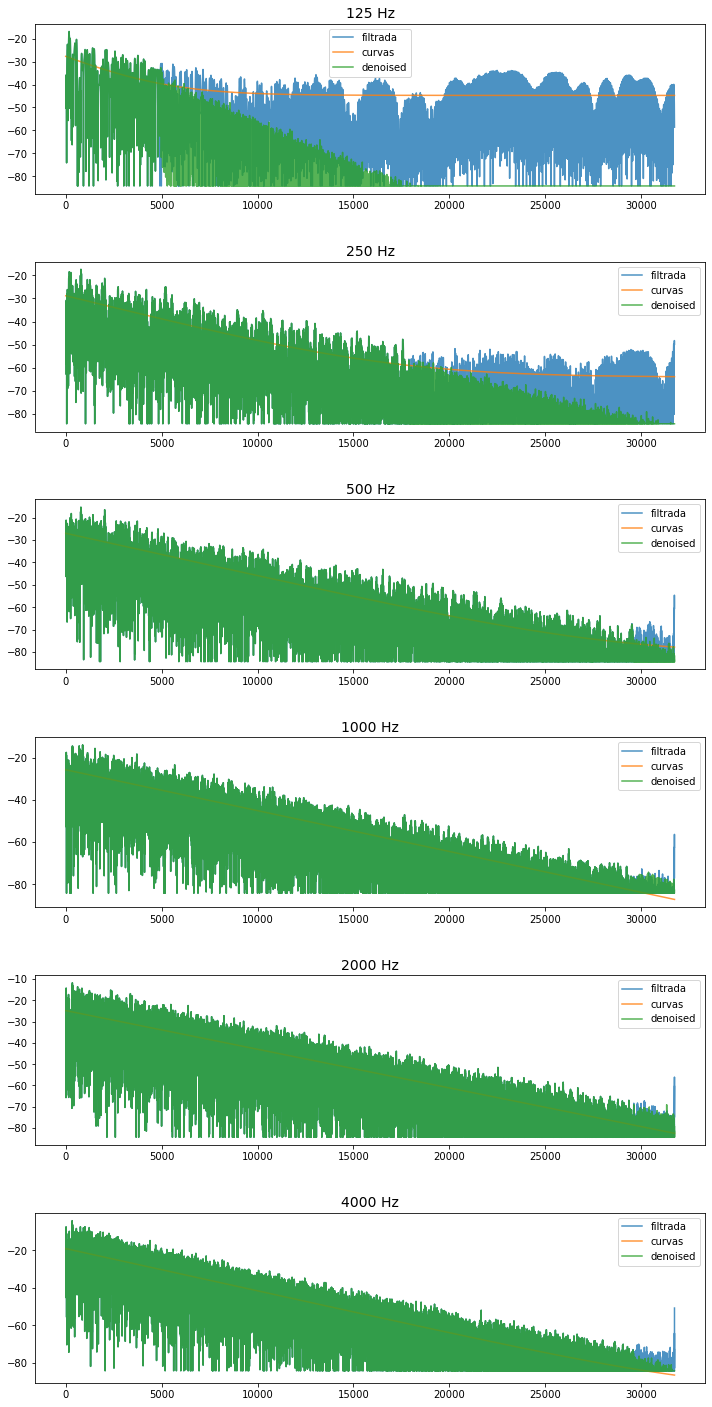

In [4]:
bands = filterbank.apply(rir)
bands_db = librosa.amplitude_to_db(bands)

curves = np.empty(bands.shape)
denoised = np.empty(bands.shape)
bands_params = []
noise_onsets = []
for band in range(len(bands)):
    # obtain curve fit params
    band_params = curve_fit(t, bands[band,:])
    bands_params.append(band_params)
    
    # generate estimated curves
    curve = curve_model(t, *band_params)
    curves[band, :] = curve
    
    # get noise floor onset
    noise_floor = 20 * np.log10(band_params[-1])
    try:
        noise_onset = np.where(curves[band] < noise_floor + 5)[0][0]
    except:
        noise_onset = len(curves[band])-2000
        
    noise_onsets.append(noise_onset)
    
    # merge to avoid noise floor 
    denoised[band,:] = noise_crossfade(t, bands[band,:], band_params, noise_onset)

band_plot(filtrada=bands_db, curvas=curves, denoised=librosa.amplitude_to_db(denoised))

## Augmentation of decay 

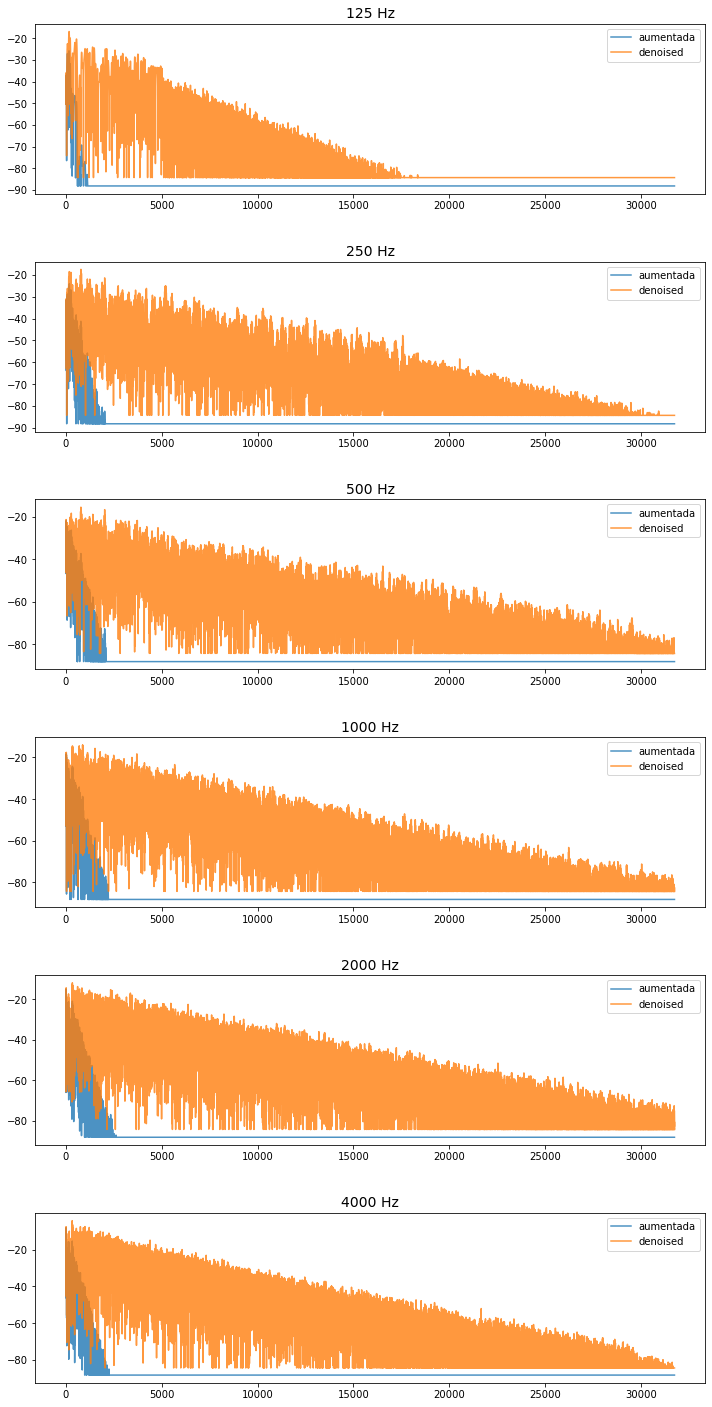

In [10]:
TR60_desired = 0.10


bands = filterbank.apply(rir)
bands_db = librosa.amplitude_to_db(bands)

curves = np.empty(bands.shape)
denoiseds = np.empty(bands.shape)
bands_aug = np.empty(bands.shape)

bands_params = []
noise_onsets = []

for band in range(len(bands)):
    # obtain curve fit params
    band_params = curve_fit(t, bands[band,:])
    bands_params.append(band_params)
    
    # generate estimated curves
    curve = curve_model(t, *band_params)
    curves[band, :] = curve
    
    # get noise floor onset
    noise_floor = 20 * np.log10(band_params[-1])
    try:
        noise_onset = np.where(curves[band] < noise_floor + 5)[0][0]
    except:
        noise_onset = len(curves[band])-2000
        
    noise_onsets.append(noise_onset)
    
    # merge to avoid noise floor 
    denoised = noise_crossfade(t, bands[band,:], band_params, noise_onset)
    denoiseds[band,:] = denoised
    
    # decay augmentation
    band_aug = augmentation(t, denoised, band_params, fullband_params[1] ,TR60_desired)
    bands_aug[band,:] = band_aug
    
band_plot(aumentada=librosa.amplitude_to_db(bands_aug), denoised=librosa.amplitude_to_db(denoiseds))

# Proceso completo

In [7]:
#Constantes a definir
TR60_desired = 0.15

impulso = RIR('../files/rir.wav', fs=params['fs'])
delay, early, rir = preprocess_rir(impulso.rir, impulso.fs) # rir = late
t = np.linspace(0, len(rir)/impulso.fs, len(rir)) # vector temporal

fullband_params = curve_fit(t, rir) # Am, decay, noise_floor

bands = filterbank.apply(rir)
bands_aug = np.empty(bands.shape)

for band in range(len(bands)):
    # obtain curve fit params
    band_params = curve_fit(t, bands[band,:])
    
    # generate estimated curves
    curve = curve_model(t, *band_params)
    
    # get noise floor onset
    noise_floor = 20 * np.log10(band_params[-1])
    try:
        noise_onset = np.where(curves[band] < noise_floor + 5)[0][0]
    except:
        noise_onset = len(curves[band])-2000
    
    # merge to avoid noise floor 
    denoised = noise_crossfade(t, bands[band,:], band_params, noise_onset)
    
    # decay augmentation
    band_aug = augmentation(t, denoised, band_params, fullband_params[1] ,TR60_desired)
    bands_aug[band,:] = band_aug

rir_aug = np.sum(bands_aug, axis=0)
rir_aug = np.concatenate((delay, early, rir_aug))

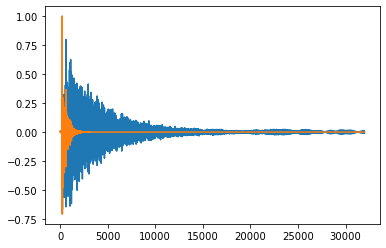

In [8]:
plt.plot(impulso.rir)
plt.plot(rir_aug)

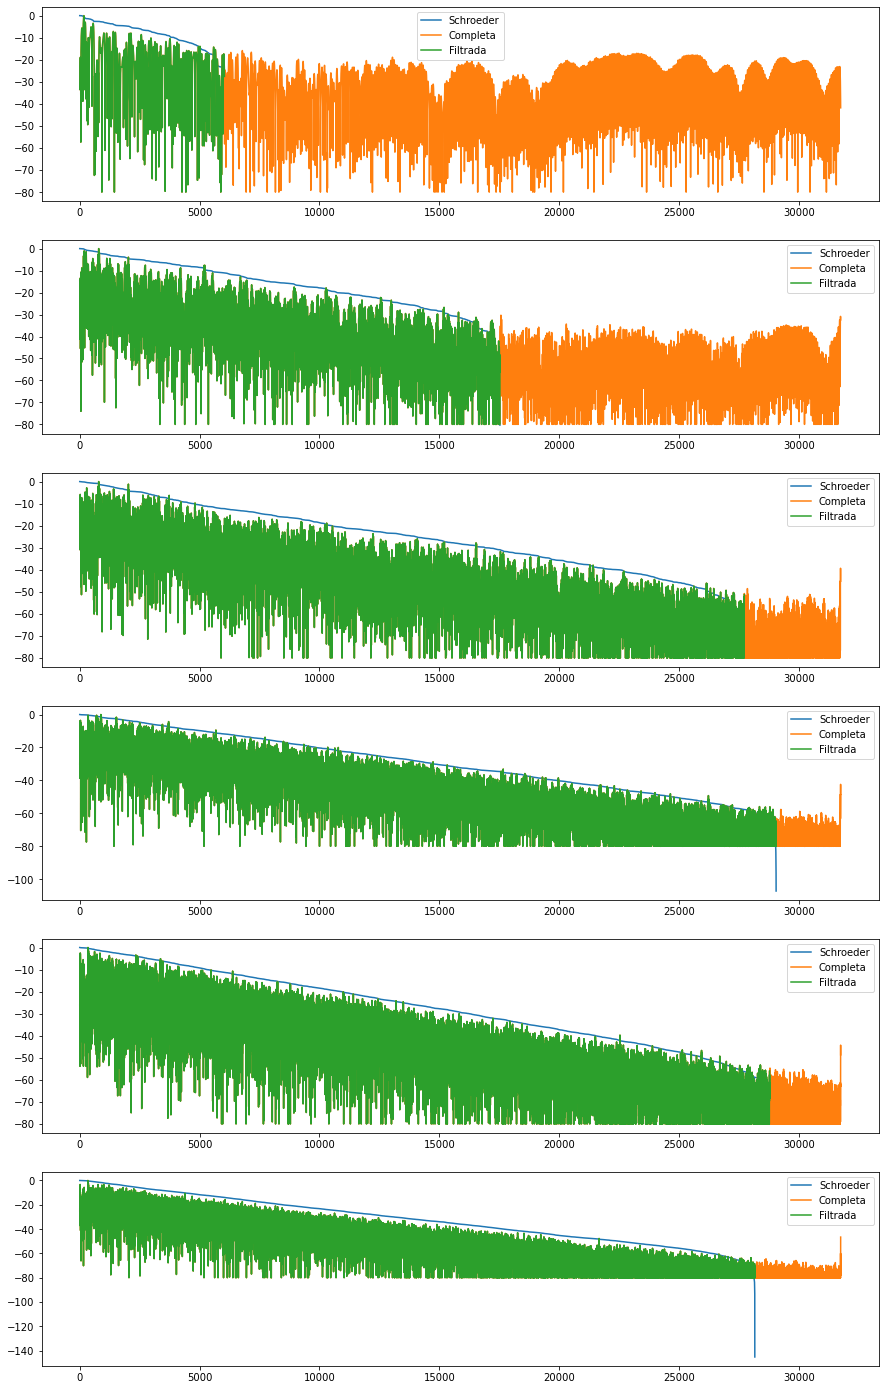

In [9]:
acoustics_rir = Acoustic_params(impulso.rir, impulso.fs)                                                                                     
tr_rir = acoustics_rir.reverberation_time(filterbank, plot = True)

acoustics_aug = Acoustic_params(rir_aug, impulso.fs)                                                                                     
tr_aug = acoustics_aug.reverberation_time(filterbank, plot = False)

(0.0, 5.0)

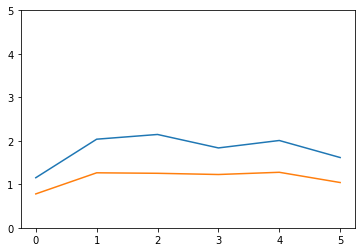

In [28]:
plt.plot(tr_rir)
plt.plot(tr_aug)
plt.ylim(0,5)

In [29]:
def get_trmid(filterbank, rir, fs):
    acoustics_rir = Acoustic_params(rir, fs)                                                                                     
    tr = acoustics_rir.reverberation_time(filterbank, plot = False)
    tr_mid = (tr[2]+tr[3])/2
    return tr_mid

In [33]:
get_trmid(filterbank, rir, 16000)

First estimation of noise floor: -18.06 dB
New time interval: 0.0010 seconds
uso el intervalo
Nueva estimacion del piso de ruido de -24.09 dB
uso el intervalo
Nueva estimacion del piso de ruido de -24.18 dB
uso el intervalo
Nueva estimacion del piso de ruido de -24.17 dB
uso el intervalo
Nueva estimacion del piso de ruido de -24.17 dB
uso el intervalo
Nueva estimacion del piso de ruido de -24.17 dB
First estimation of noise floor: -35.86 dB
New time interval: 0.1200 seconds
uso el intervalo
Nueva estimacion del piso de ruido de -29.31 dB
uso el intervalo
Nueva estimacion del piso de ruido de -29.31 dB
uso el intervalo
Nueva estimacion del piso de ruido de -29.31 dB
uso el intervalo
Nueva estimacion del piso de ruido de -29.31 dB
uso el intervalo
Nueva estimacion del piso de ruido de -29.31 dB
First estimation of noise floor: -55.94 dB
New time interval: 0.1195 seconds
uso la tail
Nueva estimacion del piso de ruido de -48.00 dB
uso la tail
Nueva estimacion del piso de ruido de -48.00 dB

1.9983374371505334